In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as pl
import pandas as pd

In [2]:
cdf=xr.open_dataset('data/obs/CERES_EBAF-TOA_Ed4.2_Subset_200003-202402.nc')

ctoa=cdf.gtoa_net_all_mon.rolling(time=12, center=True).mean().dropna("time")


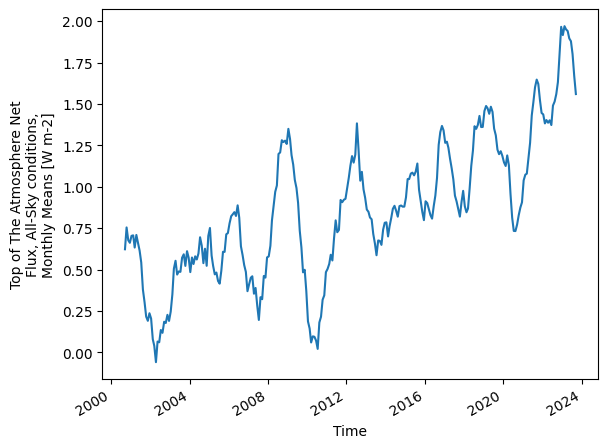

In [3]:
ctoa.plot()

In [4]:
gco2=pd.read_csv('https://climate.metoffice.cloud/formatted_data/co2_Mauna%20Loa%20CO2.csv')

gco2['Date']=pd.to_datetime([f'{y}-{m}-01' for y, m in zip(gco2.Year, gco2.Month)])
gco2=gco2.set_index('Date')

In [5]:
gco2['Mauna Loa CO2 uncertainty']

Date
1958-03-01   NaN
1958-04-01   NaN
1958-05-01   NaN
1958-06-01   NaN
1958-07-01   NaN
              ..
2023-12-01   NaN
2024-01-01   NaN
2024-02-01   NaN
2024-03-01   NaN
2024-04-01   NaN
Name: Mauna Loa CO2 uncertainty, Length: 794, dtype: float64

<Axes: xlabel='Date'>

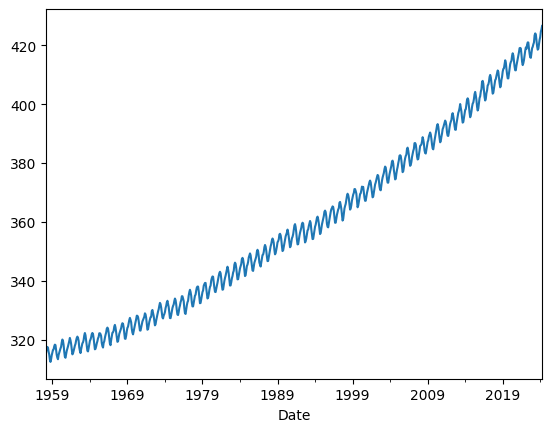

In [6]:
gco2['Mauna Loa CO2 (ppm)'].plot()

In [7]:
tsrc=['HadCRUT5','NOAAGlobalTemp','GISTEMP','ERA5','JRA-55','Berkeley%20Earth']
tmp=[]
for ts in tsrc:
  gtas=pd.read_csv('https://climate.metoffice.cloud/formatted_data/gmt_'+ts+'.csv')
  gtas['Date']=pd.to_datetime([f'{y}-06-01' for y in gtas.Year])
  gtas=gtas.set_index('Date')
  tmp.append(gtas[ts.replace('%20',' ')+' (degC)'])
gta=pd.concat(tmp,axis=1)

<Axes: xlabel='Date'>

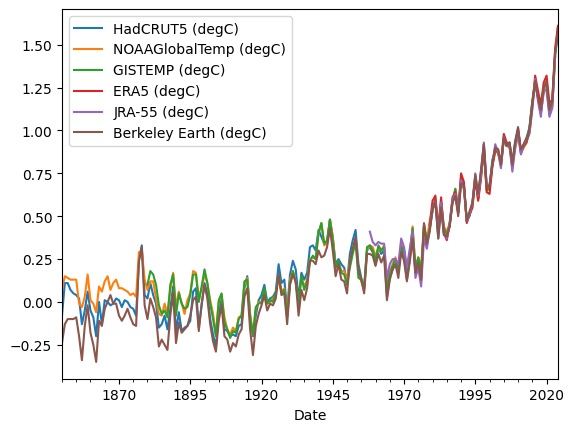

In [8]:
gta.plot()

In [9]:
ohcsrc=['EN.4.2.2.c14','Levitus','EN.4.2.2.c13','EN.4.2.2.g10','EN.4.2.2.l09','IAP','JMA']

tmp=[]
for ts in ohcsrc:
  gohc=pd.read_csv('https://climate.metoffice.cloud/formatted_data/ohc_'+ts+'.csv')
  gohc['Date']=pd.to_datetime([f'{y}-06-01' for y in gohc.Year])
  gohc=gohc.set_index('Date')
  tmp.append(gohc[ts.replace('%20',' ')+' (10ZJ)'])
gohc=pd.concat(tmp,axis=1)

<Axes: xlabel='Date'>

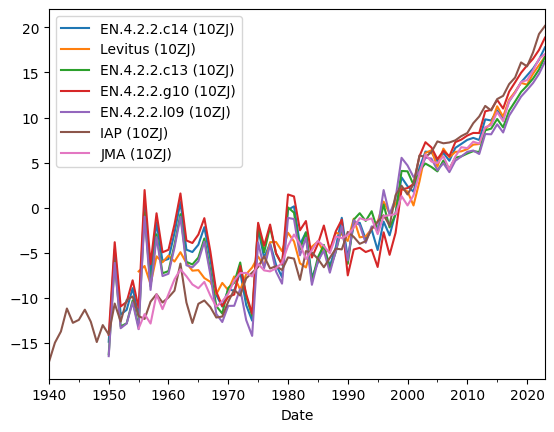

In [10]:
gohc.plot()

In [11]:
store = pd.HDFStore('data/data.h5','r')
targ = store['targ']
store.close()

In [12]:
obsm={}
obsm['dT_glob']=gta['HadCRUT5 (degC)']
obsm['OHC700']=gohc['IAP (10ZJ)']
obsm['concentrations-CO2']=gco2['Mauna Loa CO2 (ppm)']
obsm['RIB_glob']=ctoa.to_pandas()



In [13]:
vars=targ.columns.get_level_values(0).unique()
tims=targ.columns.get_level_values(1).unique()

In [14]:
tmp=np.NaN*np.zeros((len(vars),len(tims)))
utmp=np.NaN*np.zeros((len(vars),len(tims)))

for i,v in enumerate(vars):
    for j,t in enumerate(tims):
        a=obsm[v].loc[str(t-5):str(t+5)].mean()
        tmp[i,j]=a
        b=obsm[v].loc[str(t-5):str(t+5)].std()
        utmp[i,j]=b
obsmat=pd.DataFrame(tmp,columns=tims,index=vars)
obsuncmat=pd.DataFrame(utmp,columns=tims,index=vars)


In [15]:

obs=obsmat.T.unstack()

In [16]:

obsunc=obsuncmat.T.unstack()

In [17]:
store = pd.HDFStore('data/obs.h5')
store['obs'] = obs
store['obsunc'] = obsunc
store.close()